Laboratory 2: Computer Vision

- Part 2: Debiasing Facial Detection Systems

In the second portion of the lab, we'll explore two prominent aspects of applied deep learning: facial detection and algorithmic bias.

Deploying fair, unbiased AI sysmtems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face ? This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics.

In this lab, we'll investigate one [[recently published approach](https://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf)] to addressing algorithmic bias. We'll build a facial detection model that learns the latent variables underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigatin any bias that may be present in order to train a debiased model.

Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

In [ ]:
import IPython
import IPython.display

IPython.display.YouTubeVideo("59bMh59JQDo")

Let's get started by installing the relevant dependencies.

In [5]:
import comet_ml
import mitdeeplearning as mdl

# TODO: ENTER YOUR API KEY HERE !!
COMET_API_KEY = "IfAOqB1pulTvZR0qAUE9qFPjW"

# Check that we are using a GPU
#assert torch.cuda.is_available(), "Please enable GPU"
assert COMET_API_KEY != "", "Please insert your Comet API Key"


In [6]:
import os
import random
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [7]:
# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
    raise ValueError("GPU is not available. Change colab runtime")

ValueError: GPU is not available. Change colab runtime

2.1 Datasets

We'll be using three datasets in this lab. In order to train our facial detection models. we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about potencial bias of our learned models against certain demographics, it's importat that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender.

 - 1. Positive training data: CelebA Dataset. A large-scale (over 200k images) of celebrity faces.
 - 2. Negative training data: ImageNet. Many images across many different categories. We'll take negative examples from a variaty of non-human categories.
      Fitzpatrick Scale skin type classification system, with each image labeled as "Ligther" or "Darker".

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.


In [9]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)

# Instantiate a TrainingDatasetLoader using the donwloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

100%|██████████| 1.18G/1.18G [02:09<00:00, 9.74MB/s]


Opening C:\Users\anthonny.paz\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100

In [10]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [11]:
B, C, H, W = images.shape

Play around with displaying images to get a sense of what the training data actually looks like!

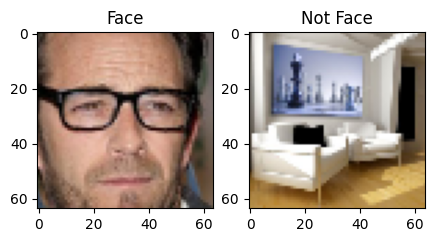

In [18]:
### Examining the CelebA training dataset ###

# @title Change the sliders to look at positive and negative training examples@ { run: "auto"}

face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)

idx_face = 23 # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9 # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title('Face')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title('Not Face')
plt.grid(False)

Thiking about bias

Remember we'll be training our facial detection classifiers on the large, well-cureated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an indepedent test dataset. Our goal is to build a model that trains on CelebA and achieves high classification accuracy on the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about latent variables, variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term latent space to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier biased if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab.

2.2 CNN for Facial Detection

First, we'll define and train a CNN on the facil classification task, and evaluate its accuracy. Later, we'll evaluate the perfomance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

Define and train the CNN Model

Like we did in the first part of the lab, we'll define our CNN Model, and then train on the CelebA and ImageNet datasets by leveraging PyTorch's automatic differentiation (torch.autograd) by using the loss.backward() and optimizer.step() functions.

In [35]:
### Define the CNN Model ###

n_filters = 12 # base number of convolutional filters
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
    """Create a standard CNN classifier."""

    # Start by first defining a convolutional block
    class ConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
            super().__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)


        def forward(self, x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)
            
            return x
    
    # Now use the block to define the classifier
    model = nn.Sequential(
        ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
        ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
        nn.Flatten(),
        nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, n_outputs),

    )

    return model.to(device)

# Call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


Now let's train the standard CNN!

In [36]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

In [37]:
### Train the standard CNN ###
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size = 32,
    num_epochs = 2,
    learning_rate = 5e-4,
)

In [38]:
experiment = create_experiment('Lab2_Part2_CNN', params)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorflow.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : innovative_fowl_7234
COMET INFO:     url                   : https://www.comet.com/anthonny20/lab2-part2-cnn/d1c92045997d45a891fc09aef0c0a97a
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (220 bytes)
COMET INFO:     installed packages       : 1
COME

In [39]:
# Defining our optimizer
optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params['learning_rate']
)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear() # clear if it exists

# set the model to train mode
standard_classifier.train() 

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

In [40]:
def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # clear the gradients
    optimizer.zero_grad()

    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)

    # Backpropagation
    loss.backward()
    optimizer.step()

In [41]:
# The Training Loop
step = 0
for epoch in range(params['num_epochs']):
    for idx in tqdm(range(loader.get_train_size() // params['batch_size'])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params['batch_size'])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        experiment.log_metric('loss', loss_value, step=step)
        step += 1
experiment.end()

  0%|          | 0/3434 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'detach'

COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]
